In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as MSE
import math

#**Recurrent Neural Networks**

In [ ]:
input = pd.read_csv('/content/drive/MyDrive/data sets for google collab/project mtech/Data sets/new data gen/initial/Input.csv')
output = pd.read_csv('/content/drive/MyDrive/data sets for google collab/project mtech/Data sets/new data gen/initial/Output.csv')
disturbance = pd.read_csv('/content/drive/MyDrive/data sets for google collab/project mtech/Disturbance+added.csv')
only_input = pd.read_csv('/content/drive/MyDrive/data sets for google collab/project mtech/Only_manipulated_input.csv')
#plant_measurement_T = pd.read_csv('/content/drive/MyDrive/data sets for google collab/project mtech/test_P_measurement_0.25.csv')
states_with_noise = pd.read_csv('/content/drive/MyDrive/data sets for google collab/project mtech/True_states_PRocessnoise.csv')
plant_measurement_T = pd.read_csv('/content/drive/MyDrive/data sets for google collab/project mtech/Plant_Measurement_2.csv')


#######################################################
estimated_using_1stprinciple = pd.read_csv('/content/drive/MyDrive/data sets for google collab/project mtech/CSTR+-+State+estimation+using+1st+principle.csv')
#######################################################

input = np.asarray(input)
output = np.asarray(output)
disturbance = np.array(disturbance)
only_input = np.array(only_input)
plant_measurement_T = np.array(plant_measurement_T)
states_with_noise = np.array(states_with_noise)
estimated_using_1stprinciple = np.array(estimated_using_1stprinciple)

print('Length of the total dataset:',len(input))

#######################################################
output[:,0] = 100*output[:,0]
print('output',output)
input[:,-1]  = input[:,-1]*100
print('input',input)
#######################################################

input_train = input[:15000]  
output_train = output[:15000]    
disturbance_train = disturbance[:15000]
onlyinput_train = only_input[:15000]
plantmeasurement_train = plant_measurement_T[:15000]
statewithnoise_train = states_with_noise[:15000]

input_test = input[15000:16666]
output_test = output[15000:16666]
disturbance_test = disturbance[15000:16666]
onlyinput_test = only_input[15000:16666]
plantmeasurement_test = plant_measurement_T[15000:16666]
statewithnoise_test = states_with_noise[15000:16666]

print('Length of the training set:',len(input_train),'\nLength of test set:',len(input_test))

Length of the total dataset: 19998
output [[ 24.712 395.28 ]
 [ 23.385 395.71 ]
 [ 22.842 395.26 ]
 ...
 [ 24.233 393.27 ]
 [ 24.757 392.77 ]
 [ 25.242 392.49 ]]
input [[  0.9    13.5   393.95   26.449]
 [  0.9    13.5   395.28   24.712]
 [  0.9    13.5   395.71   23.385]
 ...
 [  0.9    13.5   393.89   23.842]
 [  0.9    13.5   393.27   24.233]
 [  0.9    13.5   392.77   24.757]]
Length of the training set: 15000 
Length of test set: 1666


In [ ]:
def Dataloader(seriesss,target,T):
     
     input_batches = []
     output_batches = []

     for i in range(len(seriesss)-T):
         x = seriesss[i:i+T]
         input_batches.append(x)

         y = target[i+T-1]
         output_batches.append(y)

     input_batches = np.asarray(input_batches)
     output_batches = np.asarray(output_batches)

     input_batches = input_batches.reshape(-1,T,4)
     output_batches = output_batches.reshape(-1,2)# change when output length changes


     return input_batches,output_batches

In [ ]:
T = 10
data = []
target = []

for item in range(len(input_train)-T):

    x = input_train[item:item+T]
    data.append(x)

    y = output_train[item+T-1]
    target.append(y)

data = np.asarray(data)
target = np.asarray(target)

print(data.shape, target.shape)

#data = data.reshape(-1,T,4)
#target = target.reshape(-1,2)   # use .reshape(-1,1) for predicting only temp

print('Shape of the dataloader:',data.shape,'\nShape of target variable', target.shape)

N = len(data)        # As now number of windows is equal to number of samples

(14990, 10, 4) (14990, 2)
Shape of the dataloader: (14990, 10, 4) 
Shape of target variable (14990, 2)


##**Data splitting**

In [ ]:
x_train = data[:13333]
y_train = target[:13333]
x_test = data[13333:]
y_test = target[13333:]

print(f' Train input set: {type(x_train), x_train.shape}, Test input: {type(x_test), x_test.shape} ')
print(f' Train target set: {type(y_train), y_train.shape}, Test target: {type(y_test), y_test.shape} ')

 Train input set: (<class 'numpy.ndarray'>, (13333, 10, 4)), Test input: (<class 'numpy.ndarray'>, (1657, 10, 4)) 
 Train target set: (<class 'numpy.ndarray'>, (13333, 2)), Test target: (<class 'numpy.ndarray'>, (1657, 2)) 


##**Loading trained weights**

In [ ]:
b_w = torch.load('/content/drive/MyDrive/data sets for google collab/project mtech/manual RNN 1/relu/orignal_vinayak/w.pt',map_location=torch.device('cpu')).detach().numpy()
b_b = torch.load('/content/drive/MyDrive/data sets for google collab/project mtech/manual RNN 1/relu/orignal_vinayak/b.pt',map_location=torch.device('cpu')).detach().numpy()
b_W_xh = torch.load('/content/drive/MyDrive/data sets for google collab/project mtech/manual RNN 1/relu/orignal_vinayak/W_xh.pt',map_location=torch.device('cpu')).detach().numpy()
b_W_hh1 = torch.load('/content/drive/MyDrive/data sets for google collab/project mtech/manual RNN 1/relu/orignal_vinayak/W_hh1.pt',map_location=torch.device('cpu')).detach().numpy()
b_b_xh = torch.load('/content/drive/MyDrive/data sets for google collab/project mtech/manual RNN 1/relu/orignal_vinayak/b_xh.pt',map_location=torch.device('cpu')).detach().numpy()
b_b_hh1 = torch.load('/content/drive/MyDrive/data sets for google collab/project mtech/manual RNN 1/relu/orignal_vinayak/b_hh1.pt',map_location=torch.device('cpu')).detach().numpy()
b_W_xh2 = torch.load('/content/drive/MyDrive/data sets for google collab/project mtech/manual RNN 1/relu/orignal_vinayak/W_xh2.pt',map_location=torch.device('cpu')).detach().numpy()
b_W_hh2 = torch.load('/content/drive/MyDrive/data sets for google collab/project mtech/manual RNN 1/relu/orignal_vinayak/W_hh2.pt',map_location=torch.device('cpu')).detach().numpy()
b_b_xh2 = torch.load('/content/drive/MyDrive/data sets for google collab/project mtech/manual RNN 1/relu/orignal_vinayak/b_xh2.pt',map_location=torch.device('cpu')).detach().numpy()
b_b_hh2 = torch.load('/content/drive/MyDrive/data sets for google collab/project mtech/manual RNN 1/relu/orignal_vinayak/b_hh2.pt',map_location=torch.device('cpu')).detach().numpy()

In [ ]:
w = np.array(b_w)
b = np.array(b_b)
W_xh = np.array(b_W_xh)
W_hh1 = np.array(b_W_hh1)
b_xh = np.array(b_b_xh)
W_xh2 = np.array(b_W_xh2)
W_hh2 = np.array(b_W_hh2)
b_xh2 = np.array(b_b_xh2)
b_hh2 = np.array(b_b_hh2)
b_hh1 = np.array(b_b_hh1)

In [ ]:
print('Weights between input and 1st hidden layer:',b_W_xh)
print('\n Bias between input and 1st hidden layer:',b_b_xh)
print('\n Weights between neurons of 1st hidden layer:',b_W_hh1)
print('\n Bias between neurons of 1st hidden layer:',b_b_hh1)

print('Weights between 1st hidden layer & 2nd hidden layer:',b_W_xh2)
print('\n Bias between 1st hidden layer & 2nd hidden layer:',b_b_xh2)
print('\n Weights between neurons of 2nd hidden layer:',b_W_hh2)
print('\n Bias between neurons of 2nd hidden layer:',b_b_hh2)

print('\n weights between 2nd h layer and output layer',b_w)
print('\n biases between 2nd h layer and output layer',b_b)

Weights between input and 1st hidden layer: [[ 0.15489575 -0.184462   -0.0970571   0.14110717]
 [-0.3328482   0.21203206 -0.07273488  0.17986812]
 [-1.0501122  -1.1425629   0.24164735  4.243517  ]
 [-0.65762264 -0.9245269   0.17949253  1.3386226 ]
 [ 0.9730504   0.9203916   0.6539526   1.7976537 ]
 [-0.1364283  -0.21829726 -0.06402592 -0.15725873]
 [-0.58655965 -0.45632723  0.28930682  3.422387  ]
 [-0.1111959   0.45359775  0.18698491  2.1220512 ]]

 Bias between input and 1st hidden layer: [ 0.09313655  0.06332939  0.14403342 -0.00939275  0.5356445  -0.07017791
  0.44112837  0.3361485 ]

 Weights between neurons of 1st hidden layer: [[ 0.23336639 -0.3221358  -0.36462808 -0.19428064  0.28193918 -0.05889103
   0.12279658 -0.19281158]
 [ 0.34691295 -0.14958788  0.26513845  0.00418666 -0.18625809  0.18173169
  -0.18767326  0.10398171]
 [-0.09773474 -0.03876161 -0.20743163  0.22272015  0.14084725 -0.08594079
   0.36286673  0.10295426]
 [-0.02130062 -0.23599091  0.34157175  0.29660672 -0.19

###**renaming the weights**

In [ ]:
wh2 = np.array(b_w,dtype=np.float32)   # output layer weights (16 weights)
bh2 = np.array(b_b,dtype=np.float32)   # output bias (2)

wi = np.array(b_W_xh,dtype=np.float32)  # weights between input and 1st hideen layer
bi = np.array(b_b_xh,dtype=np.float32)

wh1 = np.array(b_W_xh2,dtype=np.float32) # weights between 1st and 2nd hidden layer
bh1 = np.array(b_b_xh2,dtype=np.float32)

whh1 = np.array(b_W_hh1,dtype=np.float32) # weights among 1st layer
bhh1 = np.array(b_b_hh1,dtype=np.float32)

whh2 = np.array(b_W_hh2,dtype=np.float32) # weights among 2nd layer
bhh2 = np.array(b_b_hh2,dtype=np.float32)

##**Manually coded RNN**

**Working of RNN**


> so lets say we have taken past 10 samples to predict the 11th sample. so our input data will have shape of (x,10,y) where x = total number of batches(14990) and y = number of features(4 in our case). so every batch will have 10 rows and 4 columns of past 10 instances. in RNN we take initial hidden layer values as zero usually so after every batch hidden value will become zero but as we know hidden value output go to next iteration but its only true between batches and after each batch initial value is taken not the output of 10th instance. see the codes for more understanding.



In [ ]:

def model(x_train,length):

  
  h = np.zeros(8)
  H = np.zeros(8)
############################################################################################

  out1 = []
  out2 = []
  hidden1 = []
  hidden2 = []

  for k in range(length):

    # initial hidden values after completing every batch
    h = np.zeros(8)  #1st hidden layer
    H = np.zeros(8)  # 2nd hidden layer
    
    for m in range(len(x_train[k])):  # running loop for perticular batch only

      u1 = x_train[k][m,0];u2 = x_train[k][m,1];u3 =x_train[k][m,2];u4 = x_train[k][m,3]  # inputs

      hh = []  
      for j in range(8):  # loop for 1st hidden layer neurons output
        
        a = np.array(bi[j] + (wi[j][0]*u1) + (wi[j][1]*u2) + (wi[j][2]*u3) + (wi[j][3]*u4)+
            bhh1[j]+(whh1[j][0]*h[0]) + (whh1[j][1]*h[1]) + (whh1[j][2]*h[2]) + (whh1[j][3]*h[3]) +
            (whh1[j][4]*h[4]) + (whh1[j][5]*h[5]) + (whh1[j][6]*h[6]) + (whh1[j][7]*h[7]))

        b = max(0,a)  # relu activation function
        hh.append(b)  #collecting output of each 1st hidden layer neuron so that we can send them to 2nd hidden layer

      if m==9:   # just collecing final hidden value of batch for using it in EKF
        hidden1.append(hh)

      h = hh  # just assigning new variable name for confusion reduction

      HH= []
      for i in range(8):     # loop for 2nd hidden layer neurons output

        c = np.array(bh1[i] + (wh1[i][0]*h[0])+ (wh1[i][1]*h[1]) + (wh1[i][2]*h[2]) + (wh1[i][3]*h[3]) + 
        (wh1[i][4]*h[4]) + (wh1[i][5]*h[5]) + (wh1[i][6]*h[6]) + (wh1[i][7]*h[7]) +
                bhh2[i]+(whh2[i][0]*H[0])+ (whh2[i][1]*H[1]) + (whh2[i][2]*H[2]) + (whh2[i][3]*H[3]) +
                  (whh2[i][4]*H[4]) + (whh2[i][5]*H[5]) + (whh2[i][6]*H[6]) + (whh2[i][7]*H[7]))
        
        d = max(0,c)   # relu activation function
        HH.append(d)   #collecting output of each 2nd hidden layer neuron so that we can send them to output layer
      
      if m==9:  # just collecing final hidden value of batch for using it in EKF
        hidden2.append(HH)

      H = HH   # just assigning new variable name for confusion reduction
      
      # calculating final output of RNN (2 neurons at output layer)
      o1 = bh2[0] + (wh2[0][0]*H[0])+ (wh2[0][1]*H[1]) + (wh2[0][2]*H[2]) + (wh2[0][3]*H[3]) + (wh2[0][4]*H[4]) + (wh2[0][5]*H[5]) + (wh2[0][6]*H[6]) + (wh2[0][7]*H[7])
      o2 = bh2[1] + (wh2[1][0]*H[0])+ (wh2[1][1]*H[1]) + (wh2[1][2]*H[2]) + (wh2[1][3]*H[3]) + (wh2[1][4]*H[4]) + (wh2[1][5]*H[5]) + (wh2[1][6]*H[6]) + (wh2[1][7]*H[7])

      if m==9:   # just collecing final output of perticular batch and it is the 11th step prediction
        out1.append(o1)
        out2.append(o2)

  out2 = np.array(out2)
  out1 = np.array(out1)

    
  return out1,out2,hidden1,hidden2


In [ ]:
out1,out2,_,_ = model(x_train,len(x_train))

In [ ]:
print('concentration: ',out1[:10],'Temperature: ',out2[:10],sep = '\n')

concentration: 
[25.88196006 25.43166129 24.92933214 24.51914045 24.33580914 24.37427609
 24.58328053 24.86268523 25.12126414 25.29344622]
Temperature: 
[392.7827203  393.3425985  393.75572982 393.92765646 393.84480217
 393.57908423 393.24007006 392.94475872 392.76977341 392.74260949]


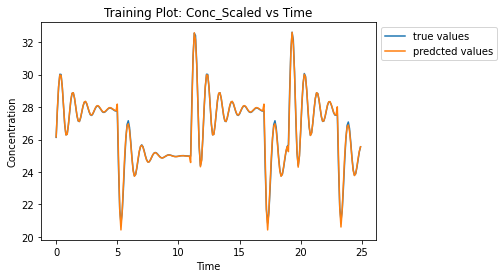

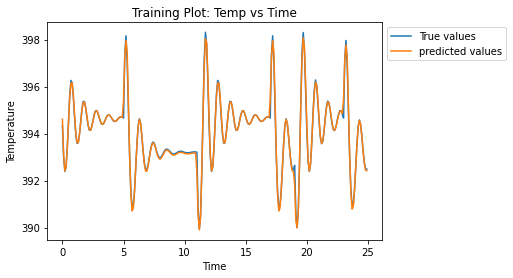

In [ ]:
true = y_train
checktrain = x_train


###########################
x = 0.1*np.arange(0,len(checktrain[200:450,0]))
plt.figure(1)
plt.plot(x,true[200:450,0], label='true values')
plt.plot(x, out1[200:450], label='predcted values')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend(bbox_to_anchor=(1, 1),loc='upper left')
plt.title('Training Plot: Conc_Scaled vs Time')
plt.savefig('conc_plots',dpi = 300)

plt.figure(2)
plt.plot(x,true[200:450,1], label='True values')
plt.plot(x, out2[200:450], label='predicted values')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend(bbox_to_anchor=(1, 1),loc='upper left')
plt.title('Training Plot: Temp vs Time')

plt.savefig('temp_plots',dpi = 300)

#**EKF Implementation**

In [ ]:
'''
this model was created when sir told me that we will start model prediction using 1st whole batch 
and after that we will use only last instance prediction not the all 10 past samples
bcz in ekf only operates in window of 1 not the window of 10

also, sir told me that past hidden values should go to next time instance while using EKf and thats why in EKF implementation we are
taking updated outputs from RNN so that we can use them in next time instant

'''

# def model_EKF(x_train,hidden1,hidden2):

  
#   if len(x_train)==10:
#     h = np.zeros(8)
#     H = np.zeros(8)

#     for m in range(len(x_train)):

      
#       u1 = x_train[m,0];u2 = x_train[m,1];u3 =x_train[m,2];u4 = x_train[m,3]

#       hh = []
#       for j in range(8):
            
#         a = np.array(bi[j] + (wi[j][0]*u1) + (wi[j][1]*u2) + (wi[j][2]*u3) + (wi[j][3]*u4)+
#             bhh1[j]+(whh1[j][0]*h[0]) + (whh1[j][1]*h[1]) + (whh1[j][2]*h[2]) + (whh1[j][3]*h[3]) +
#             (whh1[j][4]*h[4]) + (whh1[j][5]*h[5]) + (whh1[j][6]*h[6]) + (whh1[j][7]*h[7]))

#         b = max(0,a)
#         hh.append(b)
#       if m==9:
#         hidden1 = hh

#       h = hh

#       HH= []
#       for i in range(8):

#         c = np.array(bh1[i] + (wh1[i][0]*h[0])+ (wh1[i][1]*h[1]) + (wh1[i][2]*h[2]) + (wh1[i][3]*h[3]) + 
#             (wh1[i][4]*h[4]) + (wh1[i][5]*h[5]) + (wh1[i][6]*h[6]) + (wh1[i][7]*h[7]) +
#                 bhh2[i]+(whh2[i][0]*H[0])+ (whh2[i][1]*H[1]) + (whh2[i][2]*H[2]) + (whh2[i][3]*H[3]) +
#                   (whh2[i][4]*H[4]) + (whh2[i][5]*H[5]) + (whh2[i][6]*H[6]) + (whh2[i][7]*H[7]))
            
#         d = max(0,c)
#         HH.append(d)
          
#       if m==9:
#         hidden2 = HH

#       H = HH

#       if m==9:

#         out1 = bh2[0] + (wh2[0][0]*H[0])+ (wh2[0][1]*H[1]) + (wh2[0][2]*H[2]) + (wh2[0][3]*H[3]) + (wh2[0][4]*H[4]) + (wh2[0][5]*H[5]) + (wh2[0][6]*H[6]) + (wh2[0][7]*H[7])
#         out2 = bh2[1] + (wh2[1][0]*H[0])+ (wh2[1][1]*H[1]) + (wh2[1][2]*H[2]) + (wh2[1][3]*H[3]) + (wh2[1][4]*H[4]) + (wh2[1][5]*H[5]) + (wh2[1][6]*H[6]) + (wh2[1][7]*H[7])

#   else:
    
#     h = hidden1
#     H = hidden2
#     u1 = x_train[0];u2 = x_train[1];u3 =x_train[2];u4 = x_train[3]
#     hh = []
#     for j in range(8):
            
#       a = np.array(bi[j] + (wi[j][0]*u1) + (wi[j][1]*u2) + (wi[j][2]*u3) + (wi[j][3]*u4)+
#             bhh1[j]+(whh1[j][0]*h[0]) + (whh1[j][1]*h[1]) + (whh1[j][2]*h[2]) + (whh1[j][3]*h[3]) +
#             (whh1[j][4]*h[4]) + (whh1[j][5]*h[5]) + (whh1[j][6]*h[6]) + (whh1[j][7]*h[7]))

#       b = max(0,a)
#       hh.append(b)
    
#     hidden1 = hh
#     h = hh
#     HH= []
#     for i in range(8):

#       c = np.array(bh1[i] + (wh1[i][0]*h[0])+ (wh1[i][1]*h[1]) + (wh1[i][2]*h[2]) + (wh1[i][3]*h[3]) + 
#             (wh1[i][4]*h[4]) + (wh1[i][5]*h[5]) + (wh1[i][6]*h[6]) + (wh1[i][7]*h[7]) +
#                 bhh2[i]+(whh2[i][0]*H[0])+ (whh2[i][1]*H[1]) + (whh2[i][2]*H[2]) + (whh2[i][3]*H[3]) +
#                   (whh2[i][4]*H[4]) + (whh2[i][5]*H[5]) + (whh2[i][6]*H[6]) + (whh2[i][7]*H[7]))
            
#       d = max(0,c)
#       HH.append(d)
          
#     hidden2 = HH
#     H = HH

#     out1 = bh2[0] + (wh2[0][0]*H[0])+ (wh2[0][1]*H[1]) + (wh2[0][2]*H[2]) + (wh2[0][3]*H[3]) + (wh2[0][4]*H[4]) + (wh2[0][5]*H[5]) + (wh2[0][6]*H[6]) + (wh2[0][7]*H[7])
#     out2 = bh2[1] + (wh2[1][0]*H[0])+ (wh2[1][1]*H[1]) + (wh2[1][2]*H[2]) + (wh2[1][3]*H[3]) + (wh2[1][4]*H[4]) + (wh2[1][5]*H[5]) + (wh2[1][6]*H[6]) + (wh2[1][7]*H[7])


#   return out1,out2,hidden1,hidden2

In [ ]:
def EKF(x_pred, cov_est, u, yk, d,hidden1,hidden2,phi_test) :
    
    n_st =18    # (hidden states are also taken into account with process states )
    n_op = 1
    n_ip=2

    Q = np.diagflat([0.012**2,0.012**2,0.012**2,0.012**2,0.012**2,0.012**2,0.012**2,0.012**2,0.012**2,0.012**2,0.012**2,0.012**2,0.012**2,0.012**2,0.012**2,0.012**2,0.012**2,0.012**2])
     # size (18*18)

    #R = 0.25**2      ## Change if measurement noise changed
    R = np.diag([0.01**2 ,0.15**2])

    #C = [0,1]
    #C = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]      #this changed as there are 18 states now
    C= np.zeros((2,18))
    C[0][16]=1
    C[1][17]=1

    C = np.array(C)
    C = np.mat(C)   # shape remain the same just array converted into matrix type

    x_pred = x_pred.reshape(n_st,1)
    yk = yk.reshape(2,1)
    u = u.reshape(n_ip,1)
    d= d.reshape(1,1)



###############################  FOR CHECKING IF HIDDEN states VALUE 0 THEN MAKE CHANGES IN PHI ################
########################################### PHi from RNN ################################



    for i in range(len(hidden1)):

        if hidden1[i]==0:
            for j in range(18):
                phi_test[i][j]=0
                phi_test[j][i]=0

    for i in range(len(hidden2)):

        if hidden2[i]==0:
            for j in range(18):
                phi_test[i+8][j]=0
                phi_test[j][i+8]=0


    
######################################################################################

    phi_EKF = phi_test    # size (18*18)



    # one line calc gammad

    C_lin = C  # size (1*18)
    
    cov_pred = np.dot(phi_EKF,np.dot(cov_est,phi_EKF.T))  # size (18*18)
    
    #cov_pred = np.dot(phi_EKF,np.dot(cov_est,phi_EKF.T)) + gamma_bd*Q*gamma_bd.T
    kgain = np.dot(C_lin,np.dot(cov_pred,C_lin.T)) + R   # size (1*1)
    inv_kgain = kgain.I 
    K_gain = np.dot(cov_pred,np.dot(C_lin.T,inv_kgain))           # size (18*1)

    y_pred = np.dot(C_lin,x_pred)      # x_pred size (18*1)
    y_pred = y_pred.reshape(2,1)  # size (1*1)

    x_est = x_pred + np.dot(K_gain,(yk - y_pred))      # size (18*1)
    cov_est = cov_pred - np.dot(K_gain, np.dot(C_lin,cov_pred))
              
    return x_est, cov_est, phi_EKF

#**Data Generation**

In [ ]:
T = 10
def Dataloader(seriesss,target,disturbance1,mani_input,plant,mech_EKF,T):
     
     data4 = []
     output = []
     d = []
     minput = []
     pmeasurement = []
     result_1stEKF = []

     for i in range(len(seriesss)-T):
         x = seriesss[i:i+T]
         data4.append(x)

         y = target[i+T-1]
         output.append(y)

         z = disturbance1[i+T-1]
         d.append(z)

         w = mani_input[i+T-1]
         minput.append(w)

         v = plant[i+T-1]
         pmeasurement.append(v)

         f = mech_EKF[i+T-1]
         result_1stEKF.append(f)


     data4 = np.asarray(data4)
     output = np.asarray(output)
     d = np.asarray(d)
     minput = np.asarray(minput)
     pmeasurement = np.asarray(pmeasurement)
     result_1stEKF = np.asarray(result_1stEKF)


     output = output.reshape(-1,2) # change when output length changes
     d = d.reshape(-1,1)
     minput = minput.reshape(-1,2)
     pmeasurement = pmeasurement.reshape(-1,2)
     result_1stEKF = result_1stEKF.reshape(-1,2)

     return data4,output,d,minput,pmeasurement,result_1stEKF

In [ ]:
inputnew, outputnew_noisy, disturbancenew, minputnew, plantnew, mech_EKF_result = Dataloader(input_test, statewithnoise_test, disturbance_test, onlyinput_test,plantmeasurement_test,estimated_using_1stprinciple,T)

print('Disturbance shape:',disturbancenew.shape, type(disturbancenew))
print('Manipulated input shape:',minputnew.shape, type(minputnew))
print('Input shape:', inputnew.shape, type(inputnew))
print('Output shape:', outputnew_noisy.shape, type(outputnew_noisy))
print('plant measurement shape:', plantnew.shape, type(plantnew))
print('1st principle estimation shape:', mech_EKF_result.shape, type(plantnew))
print('\n')

print(inputnew.shape,outputnew_noisy.shape)
print('\nType of input data:',type(inputnew))
print('\nType of output data:',type(outputnew_noisy))

Disturbance shape: (1656, 1) <class 'numpy.ndarray'>
Manipulated input shape: (1656, 2) <class 'numpy.ndarray'>
Input shape: (1656, 10, 4) <class 'numpy.ndarray'>
Output shape: (1656, 2) <class 'numpy.ndarray'>
plant measurement shape: (1656, 2) <class 'numpy.ndarray'>
1st principle estimation shape: (1656, 2) <class 'numpy.ndarray'>


(1656, 10, 4) (1656, 2)

Type of input data: <class 'numpy.ndarray'>

Type of output data: <class 'numpy.ndarray'>


In [ ]:

W_manipulated_input = W_xh[:,:2]
W_states_input = W_xh[:,2:]

W_hidden2_xy = np.dot(W_xh2,W_states_input)
W_hidden2_xh1 = np.dot(W_xh2,W_hh1)
w_final_xy = np.dot(w,W_hidden2_xy)
w_final_xh1 = np.dot(w,W_hidden2_xh1)
w_final_xh2 =  np.dot(w,W_hh2)

In [ ]:
print('W_hh1 :', W_hh1.shape )
print('w_states_input :', W_states_input.shape )
print('W_hidden2_xh1 :', W_hidden2_xh1.shape )
print('W_hh2 :', W_hh2.shape )
print('W_hidden2_xy :', W_hidden2_xy.shape )
print('w_final_xh1 :', w_final_xh1.shape )
print('w_final_xh2 :', w_final_xh2.shape )
print('w_final_xy :', w_final_xy.shape )

W_hh1 : (8, 8)
w_states_input : (8, 2)
W_hidden2_xh1 : (8, 8)
W_hh2 : (8, 8)
W_hidden2_xy : (8, 2)
w_final_xh1 : (2, 8)
w_final_xh2 : (2, 8)
w_final_xy : (2, 2)


#**EKF implementation**

In [ ]:
validating_predictions = []

#x_est = [50,50,90,75,200,50,140,100,140,100,200,50,180,50,50,200,0.257,391.57]
#    NO NEED TO INITALIZE X(0|0) WITH 18 STATES AS X(0|0) IS REQUIRED FOR RNN AND IT ONLY REQUIRES CON(0|0) AND TEMP (0|0) 
# REST FOR EKF 1 STES ARE ADDED IN EKF FUNCTION SO AFTER 1ST ITERATION XEST(1|1) IS AUTOMATICALLY 18X18
x_est = [25.7,391.57]
x_est = np.array(x_est)
x_est_app = []

cov_est = np.diagflat([0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001])

last_x = inputnew[0]

# By doing this we are starting with x_hat_intial values which is standard procedure used for estimator

if T==10:
  last_x[9][2]=x_est[1]
  last_x[9][3]=x_est[0]
else:
  last_x[2]=x_est[1]
  last_x[3]=x_est[0]

###################################################

phi_RNN = np.zeros((18,18))

for i in range(18):
    for j in range(18):
        if i<8:       
            if j<8:
                phi_RNN[i,j]= W_hh1[i,j] 
            elif 7<j<16:
                phi_RNN[i,j] = 0
            else:
                phi_RNN[i,j] = W_states_input[i,j-16]

        if 7<i<16:
            if j<8:
                phi_RNN[i,j]=W_hidden2_xh1[i-8,j] 
            elif 7<j<16:
                phi_RNN[i,j] = W_hh2[i-8,j-8]
            else:
                phi_RNN[i,j] = W_hidden2_xy[i-8,j-16]

        if 15<i<18:
            if j<8:
                phi_RNN[i,j]= w_final_xh1[i-16,j] 
            elif 7<j<16:
                phi_RNN[i,j] = w_final_xh2[i-16,j-8]
            else:
                phi_RNN[i,j] = w_final_xy[i-16,j-16]   


phi_test = phi_RNN

######################################################
i=0
hidden1 = np.zeros(8)
hidden2 = np.zeros(8)

while len(validating_predictions)<(len(outputnew_noisy)-1):
    u = minputnew[i]
    d = 2
    d = np.array(d)
    yk = plantnew[i]  # size (1*1) Temperature data from plant

    i = i+1
    
    input_ = last_x


    p1,p2,hidden1,hidden2 = model_EKF(input_,hidden1,hidden2)

    p1 = (p1)#/100           # conc is multiple of 100 thats why returning it into orignal values
    

##################################
    '''

    when we print hidden1 and hidden1[0] they both are exactly similar but in for loop when we write only 
    hidden1 then its start giving error like reshaping that x_pred is not possible into (18,1)

    '''
    test2=[]

    for item in range(len(hidden1)):
        test2.append(hidden1[item])

    for item in range(len(hidden2)):
        test2.append(hidden2[item])

    test2.append(p1)
    test2.append(p2)
    
    p_convert = np.array(test2)

    x_est, cov_est, phi_EKF  = EKF(p_convert,cov_est,u,yk,d,hidden1,hidden2,phi_test)  

    hidden1 = []
    hidden2 = []

    for item in range(8):
        hidden1.append(float(x_est[item]))

    for item in range(8):
        hidden2.append(float(x_est[item+8]))
 
    x_est = np.array(x_est)  # size (18*1)
    
    x_est_app.append(x_est.reshape(-1,18))

    cov_est = np.array(cov_est)

    dummy = x_est.T

    validating_predictions.append(p_convert)

    if i==1:
      last_x = last_x[-1]

    last_x[0] = inputnew[i][9,0]
    last_x[1] = inputnew[i][9,1]

    last_x[2] = dummy[0,17]      # substituting Temp with predicted temp
    last_x[3] = dummy[0,16]      # substituting Temp with predicted conc

    


In [ ]:
x_est_app2 = np.array(x_est_app)
validating_predictions2 = np.array(validating_predictions)
print('Shape of EKF prediction:',x_est_app2.shape)
print('Shape of model prediction:',validating_predictions2.shape)

x_est_app2 = x_est_app2.reshape(-1,18)
validating_predictions2 = validating_predictions2.reshape(-1,18)
print('Shape of EKF prediction reshape:',x_est_app2.shape)
print('Shape of model prediction reshape:',validating_predictions2.shape)

Shape of EKF prediction: (1655, 1, 18)
Shape of model prediction: (1655, 18)
Shape of EKF prediction reshape: (1655, 18)
Shape of model prediction reshape: (1655, 18)


In [ ]:
print('concentration: ',x_est_app2[:20,16],'Temperature: ',x_est_app2[:20,17],sep = '\n')

concentration: 
[26.34241789 24.17214454 24.02447457 23.86317973 23.65475146 23.71523899
 23.76453021 25.13190577 25.62858761 27.20632452 29.22602243 30.54252421
 32.22350302 31.47128778 31.06195777 28.40749154 25.08280713 23.28537683
 24.41346828 25.08271926]
Temperature: 
[392.29646909 394.15129936 393.72519841 393.82336229 393.49295721
 392.97520302 392.48823312 391.3792228  391.31920181 390.59196472
 389.25581688 389.42747268 389.03667142 391.20299469 392.09150635
 394.86451461 396.31975715 395.73727794 393.31496683 392.42096227]


In [ ]:
print('concentration: ',outputnew_noisy[:20,0]*100,'Temperature: ',outputnew_noisy[:20,1],sep = '\n')

concentration: 
[26.77022 25.91491 24.87281 24.05821 23.57287 23.69818 24.12347 24.6885
 25.32193 25.65415 25.62245 28.99983 31.51973 32.68642 32.26242 30.46498
 27.93034 25.5923  24.55999 25.02798]
Temperature: 
[392.5748 393.6614 394.4901 394.8269 394.6004 393.993  393.2993 392.7126
 392.4032 392.4069 392.571  390.4299 389.8316 390.5852 392.392  394.7801
 396.9914 398.0231 397.3969 395.7006]


In [ ]:
print('concentration: ',mech_EKF_result[:20,0]*100,'Temperature: ',mech_EKF_result[:20,1],sep = '\n')

concentration: 
[26.39  25.363 24.651 24.267 23.711 23.676 24.16  24.749 25.536 25.659
 29.841 29.277 31.062 32.816 32.433 30.8   27.797 25.494 24.678 25.295]
Temperature: 
[393.06 393.77 394.21 394.73 394.6  393.94 393.2  392.48 392.43 392.48
 392.89 390.84 389.74 390.49 392.18 394.92 397.16 397.99 397.2  395.66]


In [ ]:
time = np.arange(0,len(x_est_app2[610:625,0]))

error_conc_EKF = MSE(outputnew_noisy[:1655,0],x_est_app2[:1655,16])
error_conc_Model = MSE(outputnew_noisy[:1655,0],validating_predictions2[:,16])

error_temp_EKF = MSE(outputnew_noisy[:1655,1],x_est_app2[:1655,17])
error_temp_Model = MSE(outputnew_noisy[:1655,1],validating_predictions2[:,17])
error_temp_Measurement = MSE(outputnew_noisy[:1655,1],plantnew[:1655,0])

error_conc_EKF_graph = outputnew_noisy[:1655,0]-x_est_app2[:1655,16]
error_conc_Model_graph = outputnew_noisy[:1655,0]-validating_predictions2[:,16]
error_temp_EKF_graph = outputnew_noisy[:1655,1]-x_est_app2[:1655,17]
error_temp_Model_graph = outputnew_noisy[:1655,1]-validating_predictions2[:,17]
error_temp_Measurement_graph = outputnew_noisy[:1655,1]-plantnew[:1655,0]


error_conc_PhyEKF = MSE(outputnew_noisy[:1655,0],mech_EKF_result[:1655,0])
error_temp_PhyEKF = MSE(outputnew_noisy[:1655,1],mech_EKF_result[:1655,1])

RMSE_phyEKF_conc = np.sqrt(error_conc_PhyEKF)
RMSE_phyEKF_temp = np.sqrt(error_temp_PhyEKF)

RMSE_EKF_conc = np.sqrt(error_conc_EKF)
RMSE_EKF_temp = np.sqrt(error_temp_EKF)

print('error_conc_EKF',np.sqrt(error_conc_EKF))
print('error_conc_Model',np.sqrt(error_conc_Model))
print('error_temp_EKF',np.sqrt(error_temp_EKF))
print('error_temp_Model',np.sqrt(error_temp_Model))
print('error_temp_Measurement',np.sqrt(error_temp_Measurement))

print('\n')
print(RMSE_phyEKF_conc)
print(RMSE_phyEKF_temp)

error_conc_EKF 26.181417194225112
error_conc_Model 24.769795355036127
error_temp_EKF 3.9016655226322823
error_temp_Model 3.3011148497952965
error_temp_Measurement 367.483288508839


0.006446020934062705
0.24190789218649833


Text(0.5, 1.0, 'Temperature vs Time instant')

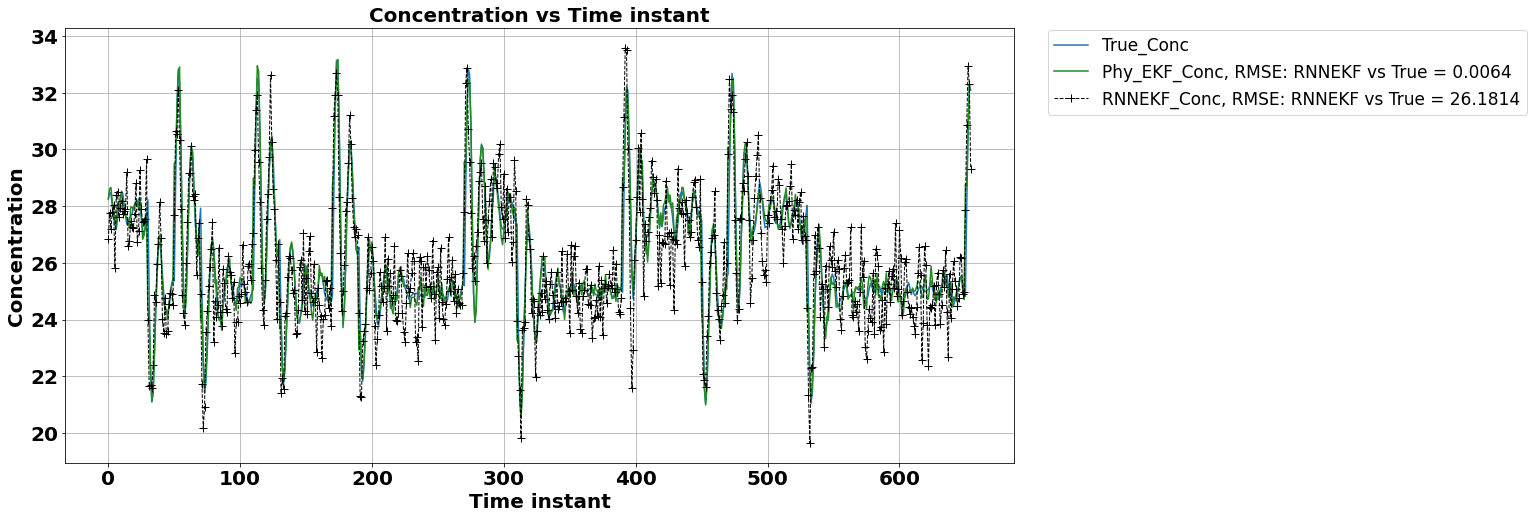

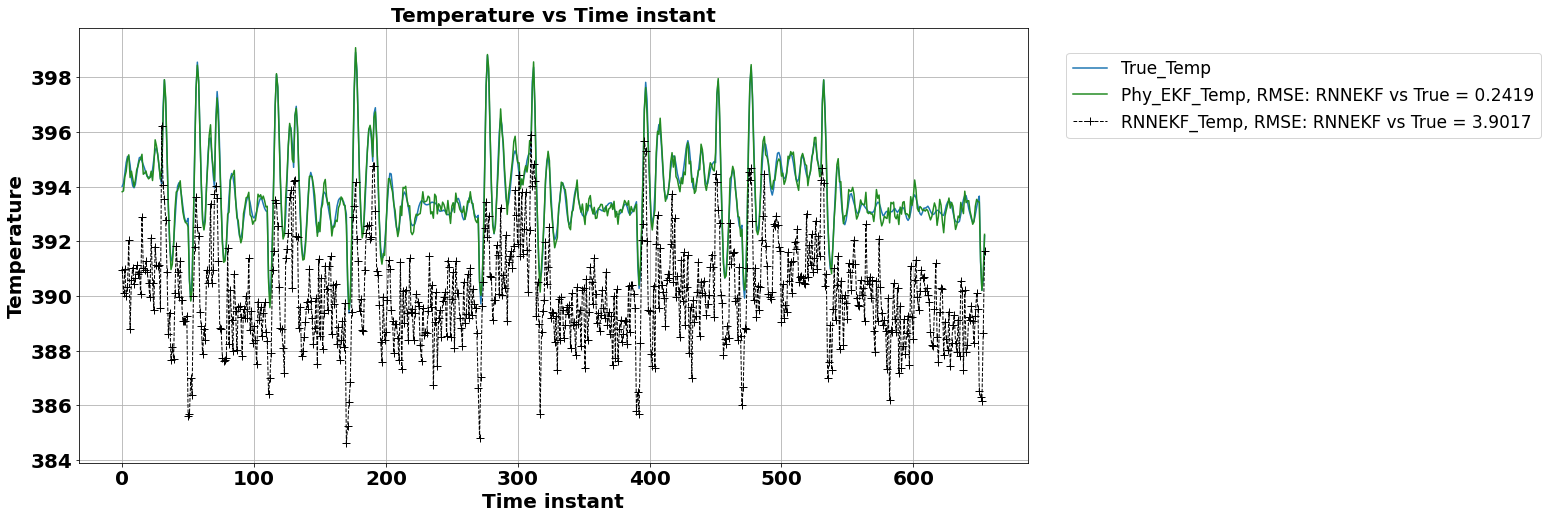

In [ ]:
time = np.arange(0,len(x_est_app2[1000:1656,0]))

plt.figure(figsize=(17,8))
plt.plot(time,outputnew_noisy[1000:1655,0]*100,label='True_Conc')
#plt.plot(time,plantnew[1000:1655,0],label='Plant_Height1')
plt.plot(time,mech_EKF_result[1000:1655,0]*100,label='Phy_EKF_Conc, RMSE: RNNEKF vs True = {0:.4f}'.format(RMSE_phyEKF_conc),color='forestgreen')
plt.plot(time,x_est_app2[1000:1655,16],'k+--',label='RNNEKF_Conc, RMSE: RNNEKF vs True = {0:.4f}'.format(RMSE_EKF_conc),linewidth=1,markersize=7.5)
#plt.plot([],[],label='RMSE Height1_EKF vs True_height1 = {0:.4f}'.format(RMSE_height1))
#plt.plot([],[],label='RMSE Height1_model vs True_height1 = {0:.4f}'.format(RMSE_height1_model))
plt.legend(bbox_to_anchor=(1.55, 0.78),loc='lower right',fontsize=17)
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
plt.grid()
plt.xlabel('Time instant',fontsize=20, fontweight='bold')
plt.ylabel('Concentration',fontsize=20, fontweight='bold')
plt.title('Concentration vs Time instant',fontsize=20, fontweight='bold')

plt.figure(figsize=(17,8))
plt.plot(time,outputnew_noisy[1000:1655,1],label='True_Temp')
#plt.plot(time,plantnew[1000:1655,0],label='Plant_Temp',linewidth=2)
plt.plot(time,mech_EKF_result[1000:1655,1],label='Phy_EKF_Temp, RMSE: RNNEKF vs True = {0:.4f}'.format(RMSE_phyEKF_temp),color='forestgreen')
plt.plot(time,x_est_app2[1000:1656,17],'k+--',label='RNNEKF_Temp, RMSE: RNNEKF vs True = {0:.4f}'.format(RMSE_EKF_temp),linewidth=1,markersize=7.5)
plt.legend(bbox_to_anchor=(1.55, 0.727),loc='lower right',fontsize=17)
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')
plt.grid()
plt.xlabel('Time instant',fontsize=20, fontweight='bold')
plt.ylabel('Temperature',fontsize=20, fontweight='bold')
plt.title('Temperature vs Time instant',fontsize=20, fontweight='bold')